## Get the dataset from the link here


In [ ]:
###### Get the dataset from this link to drive
# https://drive.google.com/drive/folders/1-CFomEmzWyWZVVqkDBwWD10CSQybqPIQ?usp=sharing

In [3]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
)
from tensorflow.keras.models import Model, Sequential
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=30ed947353a4902756b042faf17a24faa6b73d31b51758c865dc76d76fddac33
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [3]:
def load_raw_data():
     
     # Insert respective path to covid and no-covid images
    covid_path = "Path to the covid images"
    non_covid_path = "path to non_covid images"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))

    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images


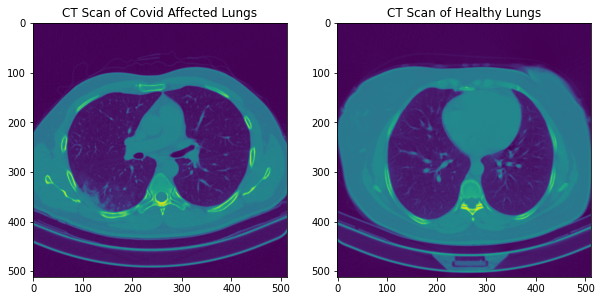

In [4]:
# To convert .png image files to .npy numpy arrays

covid_images, non_covid_images = load_raw_data()
IMG_SIZE = 128

# Two empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [5]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

COVID images converting done


In [6]:
non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done")

non covid images converting done


In [45]:
print(positive_npy.shape)
print(negative_npy.shape)

(7593, 128, 128, 1)
(6893, 128, 128, 1)


In [7]:
# To load dataset and concat them to x and y
def load_data():
    positive = positive_npy
    positive_labels = ["1" for i in positive]
    negative = negative_npy
    negative_labels = ["0" for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative])
    y = np.array((positive_labels + negative_labels), dtype=np.float32)
    return X, y

In [8]:
# CNN model
def cnn():
    model = Sequential()
    # convulutional layer
    model.add(Conv2D(32,kernel_size=5,activation="relu", input_shape=(128, 128, 1) ) )
    # Normalising after activation
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    # fully connected layer
    model.add(Dense(200, activation="relu"))
    # output
    model.add(Dense(2, activation="softmax"))
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer= keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
        metrics=["accuracy"],
    )
    return model


In [9]:
X, y = load_data()
print(X.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = cnn()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)       256       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [104]:
history_cnn = model.fit(
    X_train,
    y_train,
    epochs=20,
    workers=4,
    validation_data=(X_test, y_test),
)

Epoch 1/20
363/363 [==============================] - 10s 28ms/step - loss: 4.3602e-05 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 0.9800
Epoch 2/20
363/363 [==============================] - 10s 28ms/step - loss: 4.4790e-05 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9796
Epoch 3/20
363/363 [==============================] - 10s 27ms/step - loss: 3.8936e-05 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9793
Epoch 4/20
363/363 [==============================] - 10s 27ms/step - loss: 3.3356e-05 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9793
Epoch 5/20
363/363 [==============================] - 11s 30ms/step - loss: 3.4447e-05 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9796
Epoch 6/20
363/363 [==============================] - 10s 28ms/step - loss: 3.0828e-05 - accuracy: 1.0000 - val_loss: 0.0863 - val_accuracy: 0.9796
Epoch 7/20
363/363 [==============================] - 10s 27ms/step - loss: 2.9650e-05 - accuracy: 1.0000 - val_

## Saving the Model

In [12]:
  # insert the path for the model to be saved
model.save('Path_to_save_the_model/COVID19-Model.h5')


In [105]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(y_test, predicted).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9799861973775017


In [6]:

from tensorflow import keras
model = keras.models.load_model('Path_of_the_model/COVID19-Model.h5')

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1377
         1.0       0.99      0.97      0.98      1521

    accuracy                           0.98      2898
   macro avg       0.98      0.98      0.98      2898
weighted avg       0.98      0.98      0.98      2898



In [ ]:
# To plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title("Loss vs Epochs")
ax[0].plot(history_cnn.history["loss"])
ax[0].plot(history_cnn.history["val_loss"])
ax[0].legend(["train", "test"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_xlim(1, 20)
ax[0].set_xticks(range(1, 21))

ax[1].set_title("Accuracy vs Epochs")
ax[1].plot(history_cnn.history["accuracy"])
ax[1].plot(history_cnn.history["val_accuracy"])
ax[1].legend(["train", "test"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].set_xlim(1, 20)
ax[1].set_xticks(range(1, 21))

plt.show()

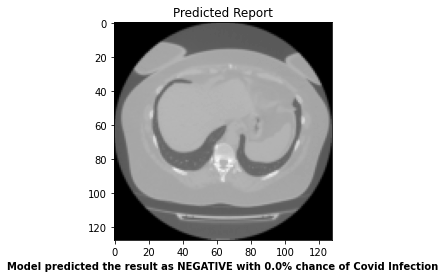

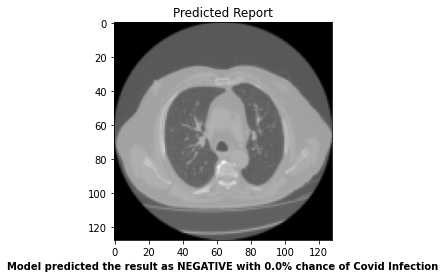

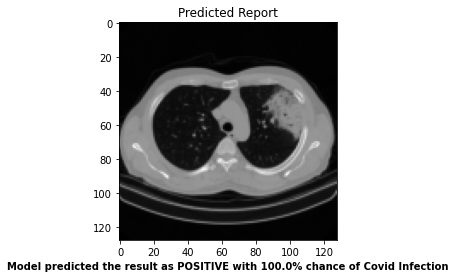

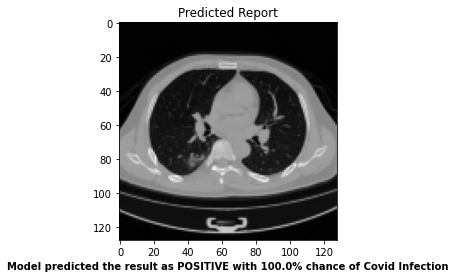

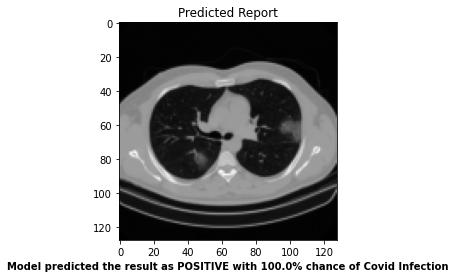

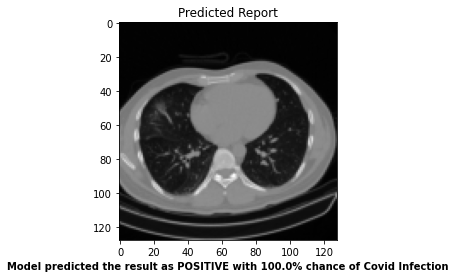

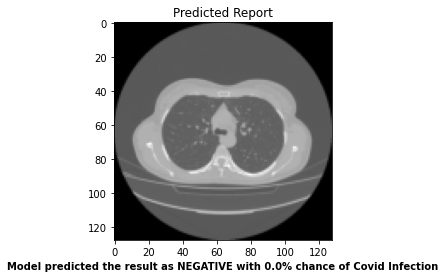

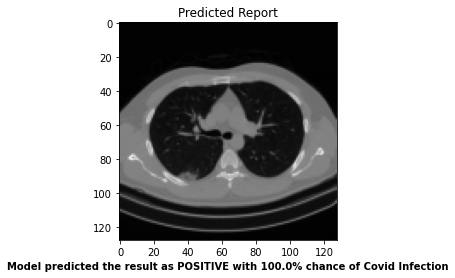

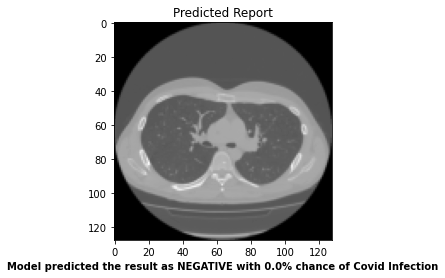

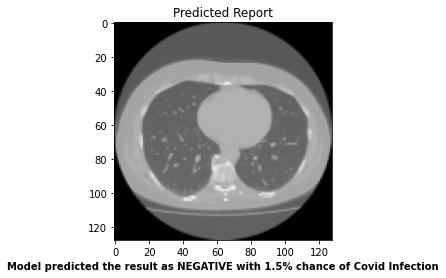

In [107]:
# To print the final report
j = 0
k = 0
for i, label in enumerate(y_pred):

    # Report for positive predicted cases
    if (np.argmax(y_pred[i]) == 1.0) and (j < 5):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as POSITIVE with "
            + str(round((np.max(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )

        plt.show()
        j = j + 1

    # Report for negative predicted cases
    if (np.argmax(y_pred[i]) == 0.0) and (k < 5):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as NEGATIVE with "
            + str(round((np.min(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )
        plt.show()
        k = k + 1

## Manually Insert Images through the button

In [47]:

# load_model_sample.py
from keras.models import load_model
import cv2
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=True):

    img = image.load_img(img_path, grayscale=True, target_size=(128, 128))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img, cmap='gray')                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [48]:
# Run this function and upload the Gray-Scale Image of CT-Scan 

def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

# Getting the current working directory 
cwd = !pwd
myImg = upload_files()

Saving 13_Bjorke_10.png to 13_Bjorke_10 (2).png


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


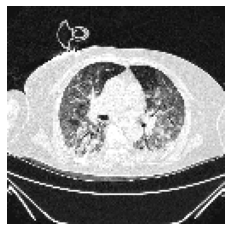

In [49]:

# Current working directory is combined with the file path upoladed through the button
img_path = f'{cwd[0]}/{myImg[0]}'

# load a single image -> load_image function read and reshape the image as per model requirements
new_image = load_image(img_path)

# check prediction
pred = model.predict(new_image)

In [50]:
result = np.argmax(pred)
if result == 1:
  print("The Patient is COVID-19 Infected")
else:
  print("The Person is Healthy and Normal ")

The Patient is COVID-19 Infected
